In [1]:
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from twitter.models import *
import parliament.models as pms
import scoping.models as sms

from django.utils.dateparse import parse_datetime

from django.db.models import Sum, Count
from django.db.models.fields import DateField
from django.db.models.functions import Cast
import textwrap as tw
import random
import datetime
p = sms.Project.objects.get(pk=134)

In [2]:
Status.objects.filter(text__icontains="kohle").count()

233100

In [3]:
s = Status.objects.filter(
    text__icontains="kohle",
    author__monitoring=True,
    author__person__isnull=True
).exclude(
    text__iregex="Kohler\W"
)
ats = s.values('author__name').annotate(
    n = Count('pk')
).order_by('-n')

kommission = set(s.distinct('author__id').values_list('author__id',flat=True))
kommission = User.objects.filter(id__in=kommission)

kommission.count()

34

In [4]:
df = pd.DataFrame.from_dict(list(ats))
df.head(30)

,author__name,n
0,Initiative Buirer für Buir,1097
1,Martin Kaiser,377
2,Hubert Weiger,370
3,BUND,323
4,IG BCE,199
5,Barbara Praetorius,90
6,Öko-Institut e.V.,69
7,Felix Chr. Matthes,69
8,DNR,68
9,Christine Herntier,63


In [5]:
s = Status.objects.filter(
    text__icontains="kohle",
)

ats = s.values('author__name').annotate(
    n = Count('pk')
).order_by('-n')

df = pd.DataFrame.from_dict(list(ats))
df.head(30)


,author__name,n
0,,2863
1,Initiative Buirer für Buir,1097
2,o je 🧡,556
3,Ende Gelände,552
4,Kohle-Protest,518
5,Heiko Stubner,458
6,Halle Verkehrt,385
7,"Dr. Julia Verlinden, MdB",383
8,Fossil Free Berlin,377
9,Martin Kaiser,377


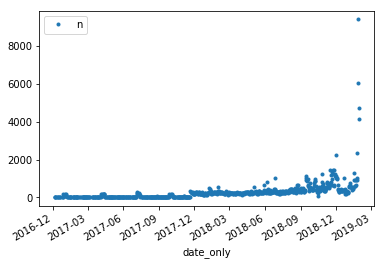

In [6]:
midnight = django.utils.timezone.make_aware(datetime.datetime.now().replace(hour=0,minute=0)) 

cutoff1 = midnight - timedelta(days=16)

cutoff2 = midnight - timedelta(days=800)

byday = s.filter(created_at__lt=cutoff1,created_at__gt=cutoff2).annotate(
    date_only=Cast('created_at', DateField())
).values('date_only').annotate(
    n = Count('pk')
).order_by('date_only')

df = pd.DataFrame.from_dict(list(byday))

df.head()

df['date_only'] = pd.to_datetime(df['date_only'])

df.plot('date_only','n', style=".")

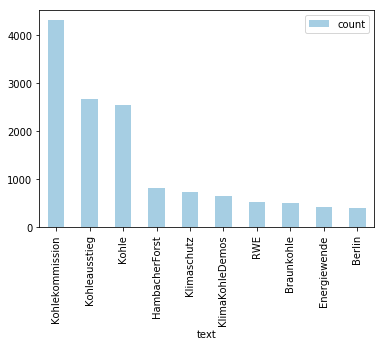

In [7]:
month = 11
cutoff1 = parse_datetime(f'2018-{month}-01T00:00:00+0000')
cutoff2 = cutoff1 + timedelta(days=30)

ttweets = Status.objects.filter(
    text__icontains="kohle",
    created_at__gt=cutoff1,
    created_at__lt=cutoff2
)

hts = []
for s in ttweets.filter(entities__hashtags__iregex='\w'):
    for hashtag in s.entities['hashtags']:
        try:
            ht = [x for x in hts if x['text']==hashtag['text']][0]
            ht['count']+=1
        except:
            ht = {"text": hashtag["text"], "count": 1}
            hts.append(ht) 
  
fig, ax = plt.subplots()

ht_df = df.from_dict(hts)
ht_df = ht_df.sort_values('count',ascending=False).head(10)
ht_df.plot.bar('text','count',colormap='Paired',ax = ax)

plt.show()

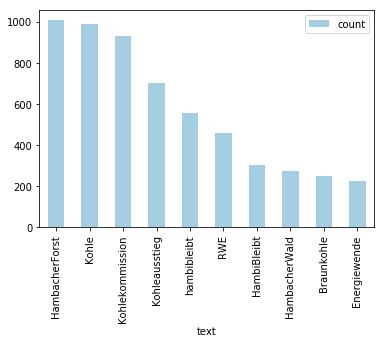

In [8]:
month = 10
cutoff1 = parse_datetime(f'2018-{month}-01T00:00:00+0000')
cutoff2 = cutoff1 + timedelta(days=30)

ttweets = Status.objects.filter(
    text__icontains="kohle",
    created_at__gt=cutoff1,
    created_at__lt=cutoff2
)

hts = []
for s in ttweets.filter(entities__hashtags__iregex='\w'):
    for hashtag in s.entities['hashtags']:
        try:
            ht = [x for x in hts if x['text']==hashtag['text']][0]
            ht['count']+=1
        except:
            ht = {"text": hashtag["text"], "count": 1}
            hts.append(ht) 
  
fig, ax = plt.subplots()

ht_df = df.from_dict(hts)
ht_df = ht_df.sort_values('count',ascending=False).head(10)
ht_df.plot.bar('text','count',colormap='Paired',ax = ax)

plt.show()

In [9]:
ttweets = set(Status.objects.filter(
    text__icontains="kohle"
).values_list('id',flat=True))

texts = Status.objects.filter(
    id__in=random.sample(ttweets, 20000)
).values_list('text',flat=True)

from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]


vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

dtm = vectorizer.fit_transform(texts)

/home/galm/software/django/tmvenv_36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gew'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [10]:
K = 20

model = NMF(
    n_components=K, random_state=1,
    alpha=0.1, l1_ratio=.1,
    init='nndsvd'
).fit(dtm)

dtm = model.transform(dtm)

In [11]:
tfidf_feature_names = vectorizer.get_feature_names()
def display_topics(model, feature_names, no_top_words, dtm, texts):
    for topic_idx, topic in enumerate(model.components_):
        tdocs = dtm[:,topic_idx]
        print(f"\n###Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        print("\n\n".join([texts[i]
                        for i in tdocs.argsort()[:-no_top_words - 1:-1]]))
        
        
no_top_words = 10
display_topics(model, tfidf_feature_names, no_top_words, dtm, list(texts))


###Topic 0
kohl raus gas strom genug halt dafur kommt komm bekomm


@HeiderFlorian @Gronkh Er denkt nur an die Kohle!! *singt* Kohle Kohle Kohle Kohhhhle Kohle Kohle

@MCDarkLord Kohle kohle kohle

 kohle kohle kohle

@JasminJoyful Kohle Kohle Kohle... Kohle kohle Kohle...

A classic :D

Der beste Gronkh Song ist immer noch der Kohle Song.Kohle Kohle Kohle Kohle Kohle Kohle! @Gronkh @GronkhTV#Gronkh #GronkhTV #MeinGronkh #YouTube #Letsplayer #Minecraft

Kohle Kohle Kohle..... Kohle Kohle Kohle..... | MINECRAFT ERLEBEN #2 | FloPlaysHD [German] [HD]: http://t.co/kGooWek1Dk via @YouTube

Kohle Kohle Kohle Kohle, des nervt meine Schwester voll. #MUUUUUUUUUUOOOOOOOIII

Let´s Play Minecraft #004 Kohle / Kohle / Kohle und nochmals Kohle XD: http://t.co/JNwquPFo6g über @YouTube

@fraugala @antscd @wissmann Kohle. Kohle. Kohle. Kohle.

@NadiineSardiine Guten Morgen ihr Gürkchen 
Kohle kohle kohle kohle

@texterstexte @breitnigge Daher finde ich den Kampf in Hannover auch wahnsinnig wichtig. De

In [12]:
ttweets = set(Status.objects.filter(
    text__icontains="kohle",
    author__monitoring=True
).values_list('id',flat=True))

texts = Status.objects.filter(
    id__in=ttweets
).values_list('text',flat=True)

from parliament.tasks import * 
stemmer = SnowballStemmer("german")
tokenizer = german_stemmer()
stopword_list = [stemmer.stem(t) for t in stopwords.words("german")]


vectorizer = CountVectorizer(max_df=0.8,
                             min_df=5,
                             max_features=10000,
                             tokenizer=tokenizer,
                             stop_words=stopword_list)

tfidf = vectorizer.fit_transform(texts)

tfidf.shape

/home/galm/software/django/tmvenv_36/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['gew'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


(7107, 2267)

In [13]:
K = 20

model = NMF(
    n_components=K, random_state=1,
    alpha=0.1, l1_ratio=.1,
    init='nndsvd'
).fit(tfidf)

dtm = model.transform(tfidf)

tfidf_feature_names = vectorizer.get_feature_names()
def display_topics(model, feature_names, no_top_words, dtm, texts):
    for topic_idx, topic in enumerate(model.components_):
        tdocs = dtm[:,topic_idx]
        print(f"\n##############################################\n### Topic {topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("\n")
        print("\n\n".join([texts[i]
                        for i in tdocs.argsort()[:-5 - 1:-1]]))
        
        
no_top_words = 10
display_topics(model, tfidf_feature_names, no_top_words, dtm, list(texts))


##############################################
### Topic 0
kohleausstieg schnell grun klimaziel diegru einleit kommt cop fdpbt jamaika


Eure Hände gegen #Kohle - Ein schneller #Kohleausstieg muss kommen. Dafür müssen wir Bundesregierung und #Kohlekommission zeigen: Deutschland steht hinter Kohleausstieg und Klimaziel 2020! Mach auch Du mit und setze ein Zeichen auf der Karte des @bund_net https://t.co/CR6uD94fHa

Appell an die Politik: Konzern-Bündnis fordert Kohleausstieg https://t.co/PM2k6e5YgT via @SPIEGELONLINE #Jamaika #Kohleausstieg

RT @hstubner: HB: Wirtschaft will Kohleausstieg an Bedingungen knüpfen - Der geplante Kohleausstieg ruft die deutsche Wirtschaft auf den Pl…

RT @klima_allianz: Liebe @CDU, Kohleausstieg ist wirtschaftliche Vernunft. Sagen nicht nur wir. #EndCoal #Kohleausstieg #Wachstum https://t…

RT @wirklimaretter: Grüne Minister forcieren Kohleausstieg: Ein Bundesgesetz soll den Rahmen für den Kohleausstieg vorgeben
 https://t.co/O…

##########################